<a href="https://colab.research.google.com/github/nandrom/senalesIII/blob/main/FeatureExtraction_EMG_Signals_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.io import loadmat
!pip install antropy
ruta = '/content/drive/MyDrive/Señales 3/Notebooks/data/FeatureExtraction/'
data = loadmat(ruta+'S1_20140620T021349.mat')
data_ACC = data['data_ACC']
data_EMG = data['data_EMG']

     |████████████████████████████████| 49 kB 3.7 MB/s 
  Created wheel for antropy: filename=antropy-0.1.4-py3-none-any.whl size=16159 sha256=05211a232046b506eaa8ff4cc525c21cc1475d54e7c1776d9093d014a4119aff
  Stored in directory: /root/.cache/pip/wheels/d4/cc/6b/28fa7036bdabc6f1f92fd6a108ae259dbb48f107f676d6b491
Successfully built antropy


In [ ]:
# Librerias y Funciones
import scipy 
import numpy as np
from scipy import signal
import pywt
import matplotlib.pyplot as plt
from scipy.stats import entropy
import antropy as ant

fs = 4e3

def featureExtractionEMG(sampleSignal):
  # Esta función toma como argumento de entrada una señal EMG de 20000 muestras y retorna 13 caracteristicas relacionadas a la señal
  # a. Removemos el nivel DC
  nivelDC = np.mean(sampleSignal)
  sampleSignal = sampleSignal-nivelDC
  # b. Normalicemos las señales para que tengan amplitud unitaria
  maxSignal = np.abs(np.max(sampleSignal))
  sampleSignal = sampleSignal/maxSignal
  # Realicemos el análisis STFT
  f, t, Zxx = signal.stft(sampleSignal, fs, nperseg=512)

  rms = np.sqrt((np.sum(sampleSignal)**2)/len(sampleSignal))
  mae = np.sum(sampleSignal)/len(sampleSignal)
  # En la matriz Zxx se tiene una matriz de #defrecs * #times
# Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]
  absZxx = np.abs(Zxx)
  Pmax_Zxx = np.max(absZxx,axis=1) # dB

  Pmax_Zxx_dB = 20*np.log10(Pmax_Zxx)
  idx = np.argsort(Pmax_Zxx_dB)
  maximos = Pmax_Zxx_dB[idx]
  auxPotmax_Zxx = maximos[-5:]
  frecuencias = f[idx]
  fPmax_Zxx = frecuencias[-5:]
  #contador de cruces x cero
  zerocrosscont = 0
  for i in range (len(sampleSignal)-1):
    if (sampleSignal[i] > 0 and sampleSignal[i+1] < 0 or sampleSignal[i] < 0 and sampleSignal[i+1] > 0):
      zerocrosscont = zerocrosscont + 1
  feature_set = np.zeros((13,))
  feature_set[0] = rms
  feature_set[1] = mae
  feature_set[2:7] = auxPotmax_Zxx
  feature_set[7:12] = fPmax_Zxx
  feature_set[12] = zerocrosscont
  return feature_set

def calculate_entropy(list_values):
  entropyVal = ant.perm_entropy(list_values, normalize=True)
  return entropyVal

def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  median = np.nanpercentile(list_values, 50)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, n95, median, mean, std, var, rms]

def calculate_crossings(list_values):
  zero_crossing_indices = np.where(np.diff(np.signbit(list_values)))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.where(np.diff(np.signbit(list_values-np.nanmean(list_values))))[0]
  no_mean_crossings = len(mean_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]

def get_features(list_values):
  entropy = calculate_entropy(list_values)
  crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy] + crossings + statistics

In [ ]:
# Primer matriz de caracteristicas que incluye potencias y frecuencias
L_Signal, Classes, Ntrials = np.shape(data_EMG)
Features_Mat = np.zeros(((Ntrials)*Classes,13))
idx= 0
for i in range(Classes):
  for j in range(Ntrials):
    sampleSignal = data_EMG[:,i,j]
    Features_Mat[idx,:] = featureExtractionEMG(sampleSignal)
    idx = idx + 1

In [ ]:
import pandas as pd
Nombres = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero']

dataFrame = pd.DataFrame(data = Features_Mat, columns= Nombres)

In [ ]:
dataFrame

RMS           MAE  ...       F5  Num Cruces Por Cero
0     9.640368e-16 -6.816769e-18  ...  54.6875               1578.0
1     7.222425e-17 -5.107026e-19  ...  54.6875               1272.0
2     3.768222e-16  2.664535e-18  ...  78.1250               1217.0
3     8.729714e-16  6.172840e-18  ...  70.3125               1251.0
4     7.662051e-16  5.417888e-18  ...  93.7500               1282.0
...            ...           ...  ...      ...                  ...
1129  5.514165e-15  3.899103e-17  ...  46.8750                773.0
1130  2.600073e-15  1.838529e-17  ...  46.8750                660.0
1131  2.951774e-16 -2.087219e-18  ...  46.8750                899.0
1132  8.415696e-16 -5.950795e-18  ...  46.8750                899.0
1133  5.181305e-15  3.663736e-17  ...  46.8750                966.0

[1134 rows x 13 columns]

In [ ]:
# Extraccion de caracteristicas de las Wavelet
nDesc = 3
waveletname = 'sym'+str(nDesc)
Features_Mat_Wt = np.zeros((Ntrials*Classes,12*(nDesc+1))) # (nDesc+1) para incluir los coeficioentes definidos de la 1er Wt
idx= 0
for i in range(Classes):
  for j in range(Ntrials):
    sampleSignal = data_EMG[:,i,j]
    for ii in range(nDesc):
      (sampleSignal, coeff_d) = pywt.dwt(sampleSignal, waveletname)
      if ii==0:
        Features_Mat_Wt[idx,ii*12:(ii+1)*12] = get_features(sampleSignal)
        Features_Mat_Wt[idx,12*nDesc:] = get_features(coeff_d)
      else:  
        Features_Mat_Wt[idx,ii*12:(ii+1)*12] = get_features(sampleSignal)
    idx = idx + 1

In [ ]:
# Etiquetas de los tipos de movimientos
Labels = np.zeros((Ntrials)*Classes)
cont= 1
for i in range ((Ntrials)*Classes):
  Labels[i] = cont
  if (i >= (Ntrials)*cont):
    cont = cont + 1
Labels = Labels.astype(np.int)
Labels

array([1, 1, 1, ..., 6, 6, 6])

In [ ]:
Nombres = ['Entropy_Wt1','no_zero_crossings_Wt1','no_mean_crossings_Wt1','n5_Wt1', 'n25_Wt1', 'n75_Wt1', 'n95_Wt1', 'median_Wt1', 'mean_Wt1', 'std_Wt1', 'var_Wt1', 'rms_Wt1','Entropy_Wt2','no_zero_crossings_Wt2','no_mean_crossings_Wt2','n5_Wt2', 'n25_Wt2', 'n75_Wt2', 'n95_Wt2', 'median_Wt2', 'mean_Wt2', 'std_Wt2', 'var_Wt2', 'rms_Wt2','Entropy_Wt3','no_zero_crossings_Wt3','no_mean_crossings_Wt3','n5_Wt3', 'n25_Wt3', 'n75_Wt3', 'n95_Wt3', 'median_Wt3', 'mean_Wt3', 'std_Wt3', 'var_Wt3', 'rms_Wt3', 'Entropy_coeff1','no_zero_crossings_coeff1','no_mean_crossings_coeff1','n5_coeff1', 'n25_coeff1', 'n75_coeff1', 'n95_coeff1', 'median_coeff1', 'mean_coeff1', 'std_coeff1', 'var_coeff1', 'rms_coeff1']

dataFrame2 = pd.DataFrame(data = Features_Mat_Wt, columns= Nombres)
dataFrame2

Entropy_Wt1  no_zero_crossings_Wt1  ...    var_coeff1  rms_coeff1
0        0.833429                 1234.0  ...  1.891241e-07    0.000340
1        0.797486                 1202.0  ...  5.848703e-07    0.000540
2        0.789564                 1179.0  ...  7.700504e-07    0.000623
3        0.782939                 1241.0  ...  8.692039e-07    0.000674
4        0.783728                 1266.0  ...  8.881684e-07    0.000689
...           ...                    ...  ...           ...         ...
1129     0.798937                  745.0  ...  1.293600e-07    0.000286
1130     0.775662                  676.0  ...  1.267377e-07    0.000283
1131     0.815520                  716.0  ...  1.196689e-07    0.000275
1132     0.811603                  682.0  ...  1.208920e-07    0.000277
1133     0.808051                  671.0  ...  1.192943e-07    0.000277

[1134 rows x 48 columns]

In [ ]:
Features_Mat_Full = np.concatenate((Features_Mat,Features_Mat_Wt),axis=1)
Nombres = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero','Entropy_Wt1','no_zero_crossings_Wt1','no_mean_crossings_Wt1','n5_Wt1', 'n25_Wt1', 'n75_Wt1', 'n95_Wt1', 'median_Wt1', 'mean_Wt1', 'std_Wt1', 'var_Wt1', 'rms_Wt1','Entropy_Wt2','no_zero_crossings_Wt2','no_mean_crossings_Wt2','n5_Wt2', 'n25_Wt2', 'n75_Wt2', 'n95_Wt2', 'median_Wt2', 'mean_Wt2', 'std_Wt2', 'var_Wt2', 'rms_Wt2','Entropy_Wt3','no_zero_crossings_Wt3','no_mean_crossings_Wt3','n5_Wt3', 'n25_Wt3', 'n75_Wt3', 'n95_Wt3', 'median_Wt3', 'mean_Wt3', 'std_Wt3', 'var_Wt3', 'rms_Wt3', 'Entropy_coeff1','no_zero_crossings_coeff1','no_mean_crossings_coeff1','n5_coeff1', 'n25_coeff1', 'n75_coeff1', 'n95_coeff1', 'median_coeff1', 'mean_coeff1', 'std_coeff1', 'var_coeff1', 'rms_coeff1']

CompletedataFrame = pd.DataFrame(data = Features_Mat_Full, columns= Nombres)
CompletedataFrame["Tipo mov"] = Labels
CompletedataFrame

RMS           MAE         P1  ...    var_coeff1  rms_coeff1  Tipo mov
0     9.640368e-16 -6.816769e-18 -23.555504  ...  1.891241e-07    0.000340         1
1     7.222425e-17 -5.107026e-19 -21.086336  ...  5.848703e-07    0.000540         1
2     3.768222e-16  2.664535e-18 -21.633771  ...  7.700504e-07    0.000623         1
3     8.729714e-16  6.172840e-18 -20.278898  ...  8.692039e-07    0.000674         1
4     7.662051e-16  5.417888e-18 -19.416449  ...  8.881684e-07    0.000689         1
...            ...           ...        ...  ...           ...         ...       ...
1129  5.514165e-15  3.899103e-17 -19.644577  ...  1.293600e-07    0.000286         6
1130  2.600073e-15  1.838529e-17 -23.586442  ...  1.267377e-07    0.000283         6
1131  2.951774e-16 -2.087219e-18 -19.941411  ...  1.196689e-07    0.000275         6
1132  8.415696e-16 -5.950795e-18 -20.160685  ...  1.208920e-07    0.000277         6
1133  5.181305e-15  3.663736e-17 -17.095496  ...  1.192943e-07    0.000277         6

[1134 rows x 62 columns]

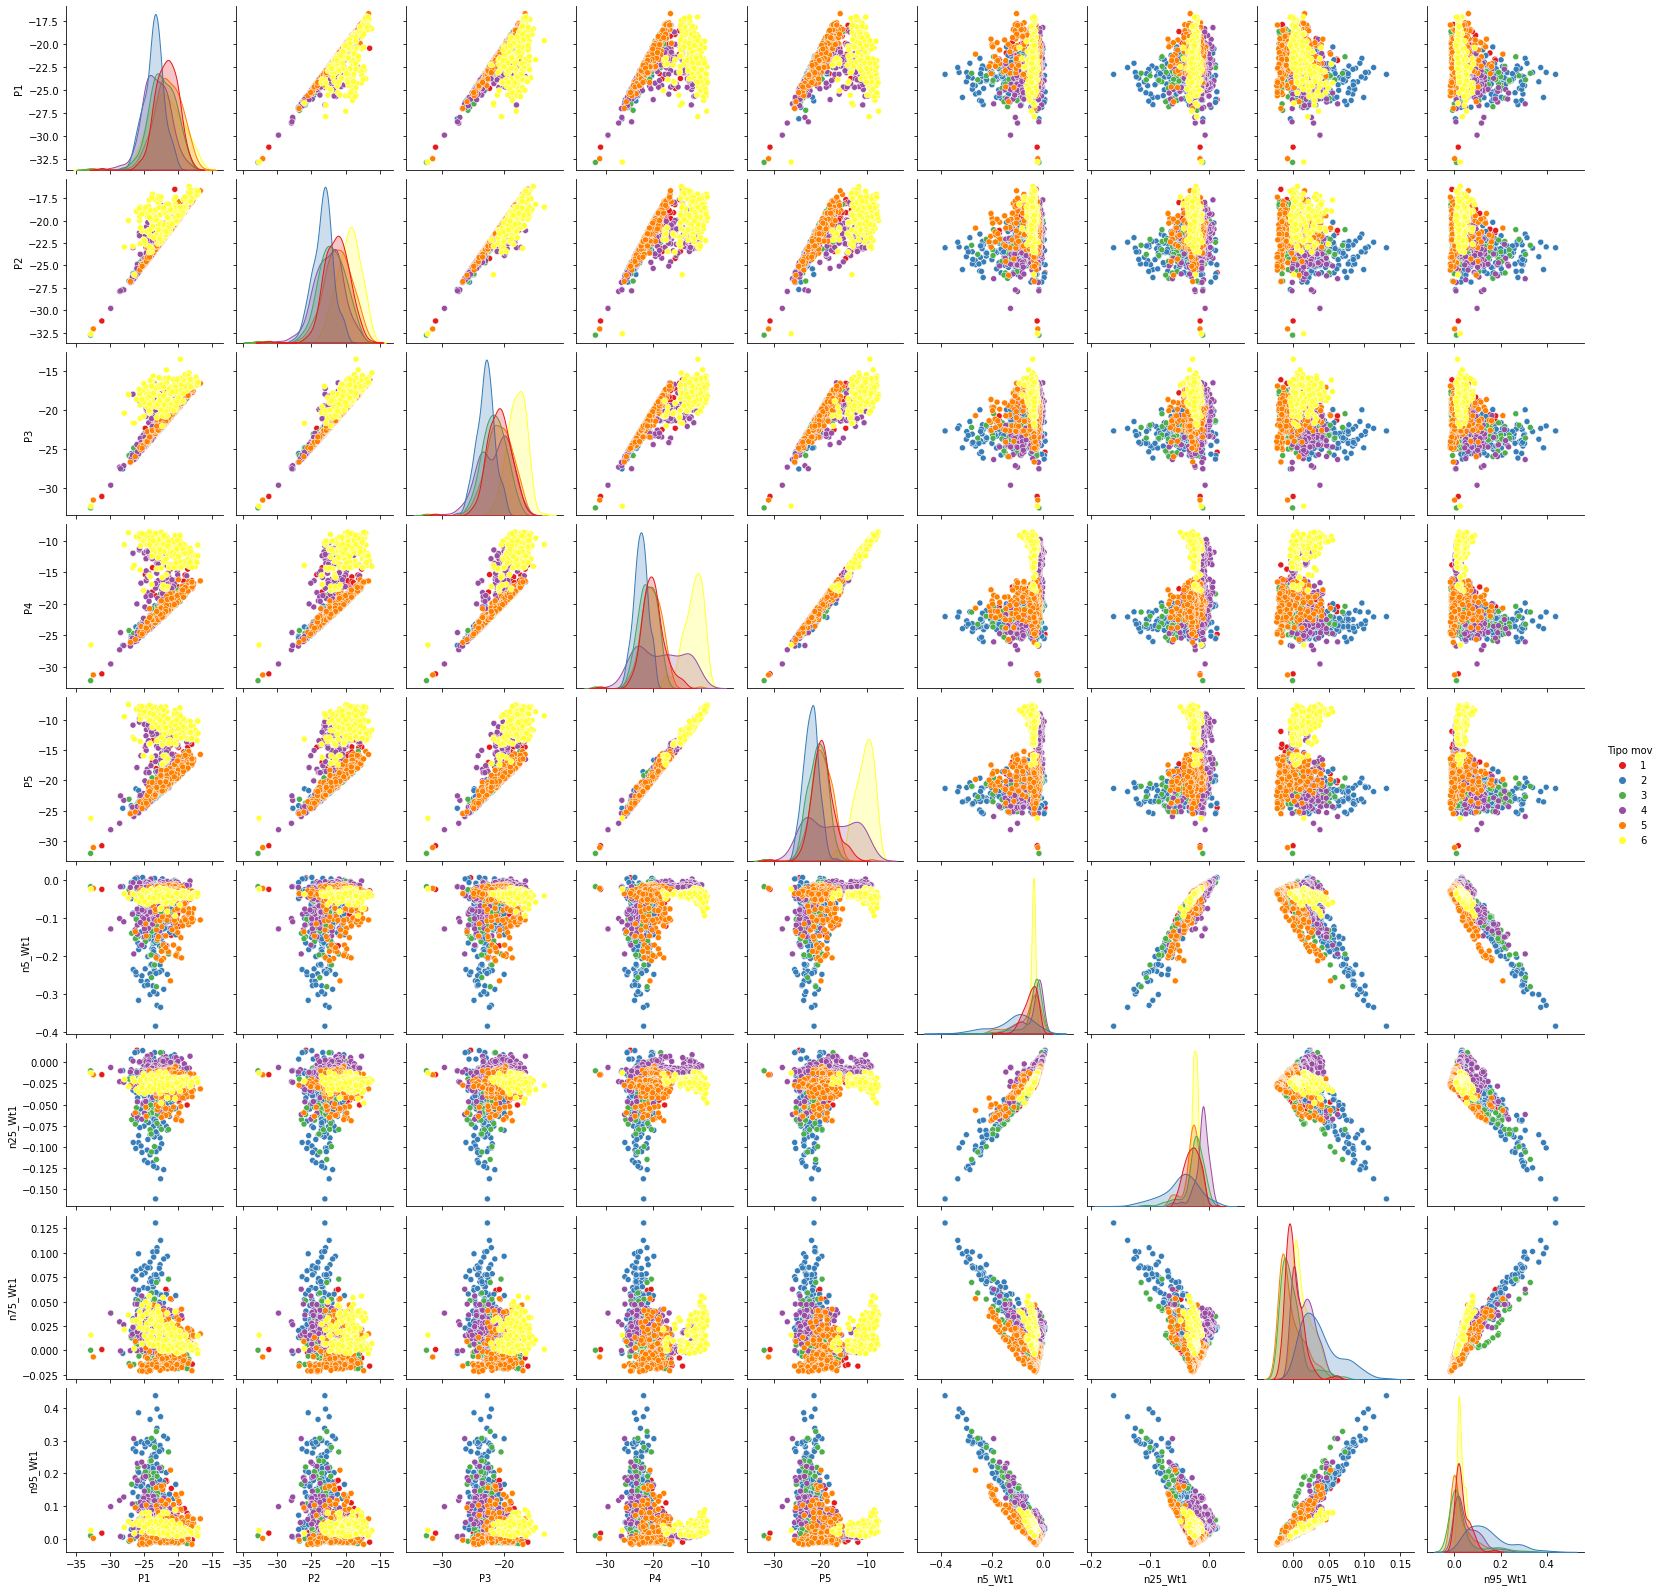

In [22]:
import seaborn as sns

subdataFrame = CompletedataFrame[['P1','P2','P3','P4','P5','n5_Wt1', 'n25_Wt1', 'n75_Wt1', 'n95_Wt1',"Tipo mov"]]

sns.pairplot(subdataFrame, hue="Tipo mov", palette =  sns.color_palette("Set1",6))

Al comparar las potencias con la primera descomposición de la transformada Wavelet, se nota una cierta definición de cada tipo de movimiento en grupos mas o menos definidos, aunque algunos datos están aun dispersos. La razón de esta segmentación puede deberse a que las potencias están directamente relacionadas con la frecuencia, esta relación nos dice que la potencia asociada a cada movimiento es proporcional a la frecuencia de la señal, por lo que una descomposición mayor podría sugerir una mayor claridad en los datos, pero primero se ha de comparar las potencias directamente con las frecuencias para verificar la relación, aunque al tener la información frecuencial completa probablemente no se pueda observar una clara relación.

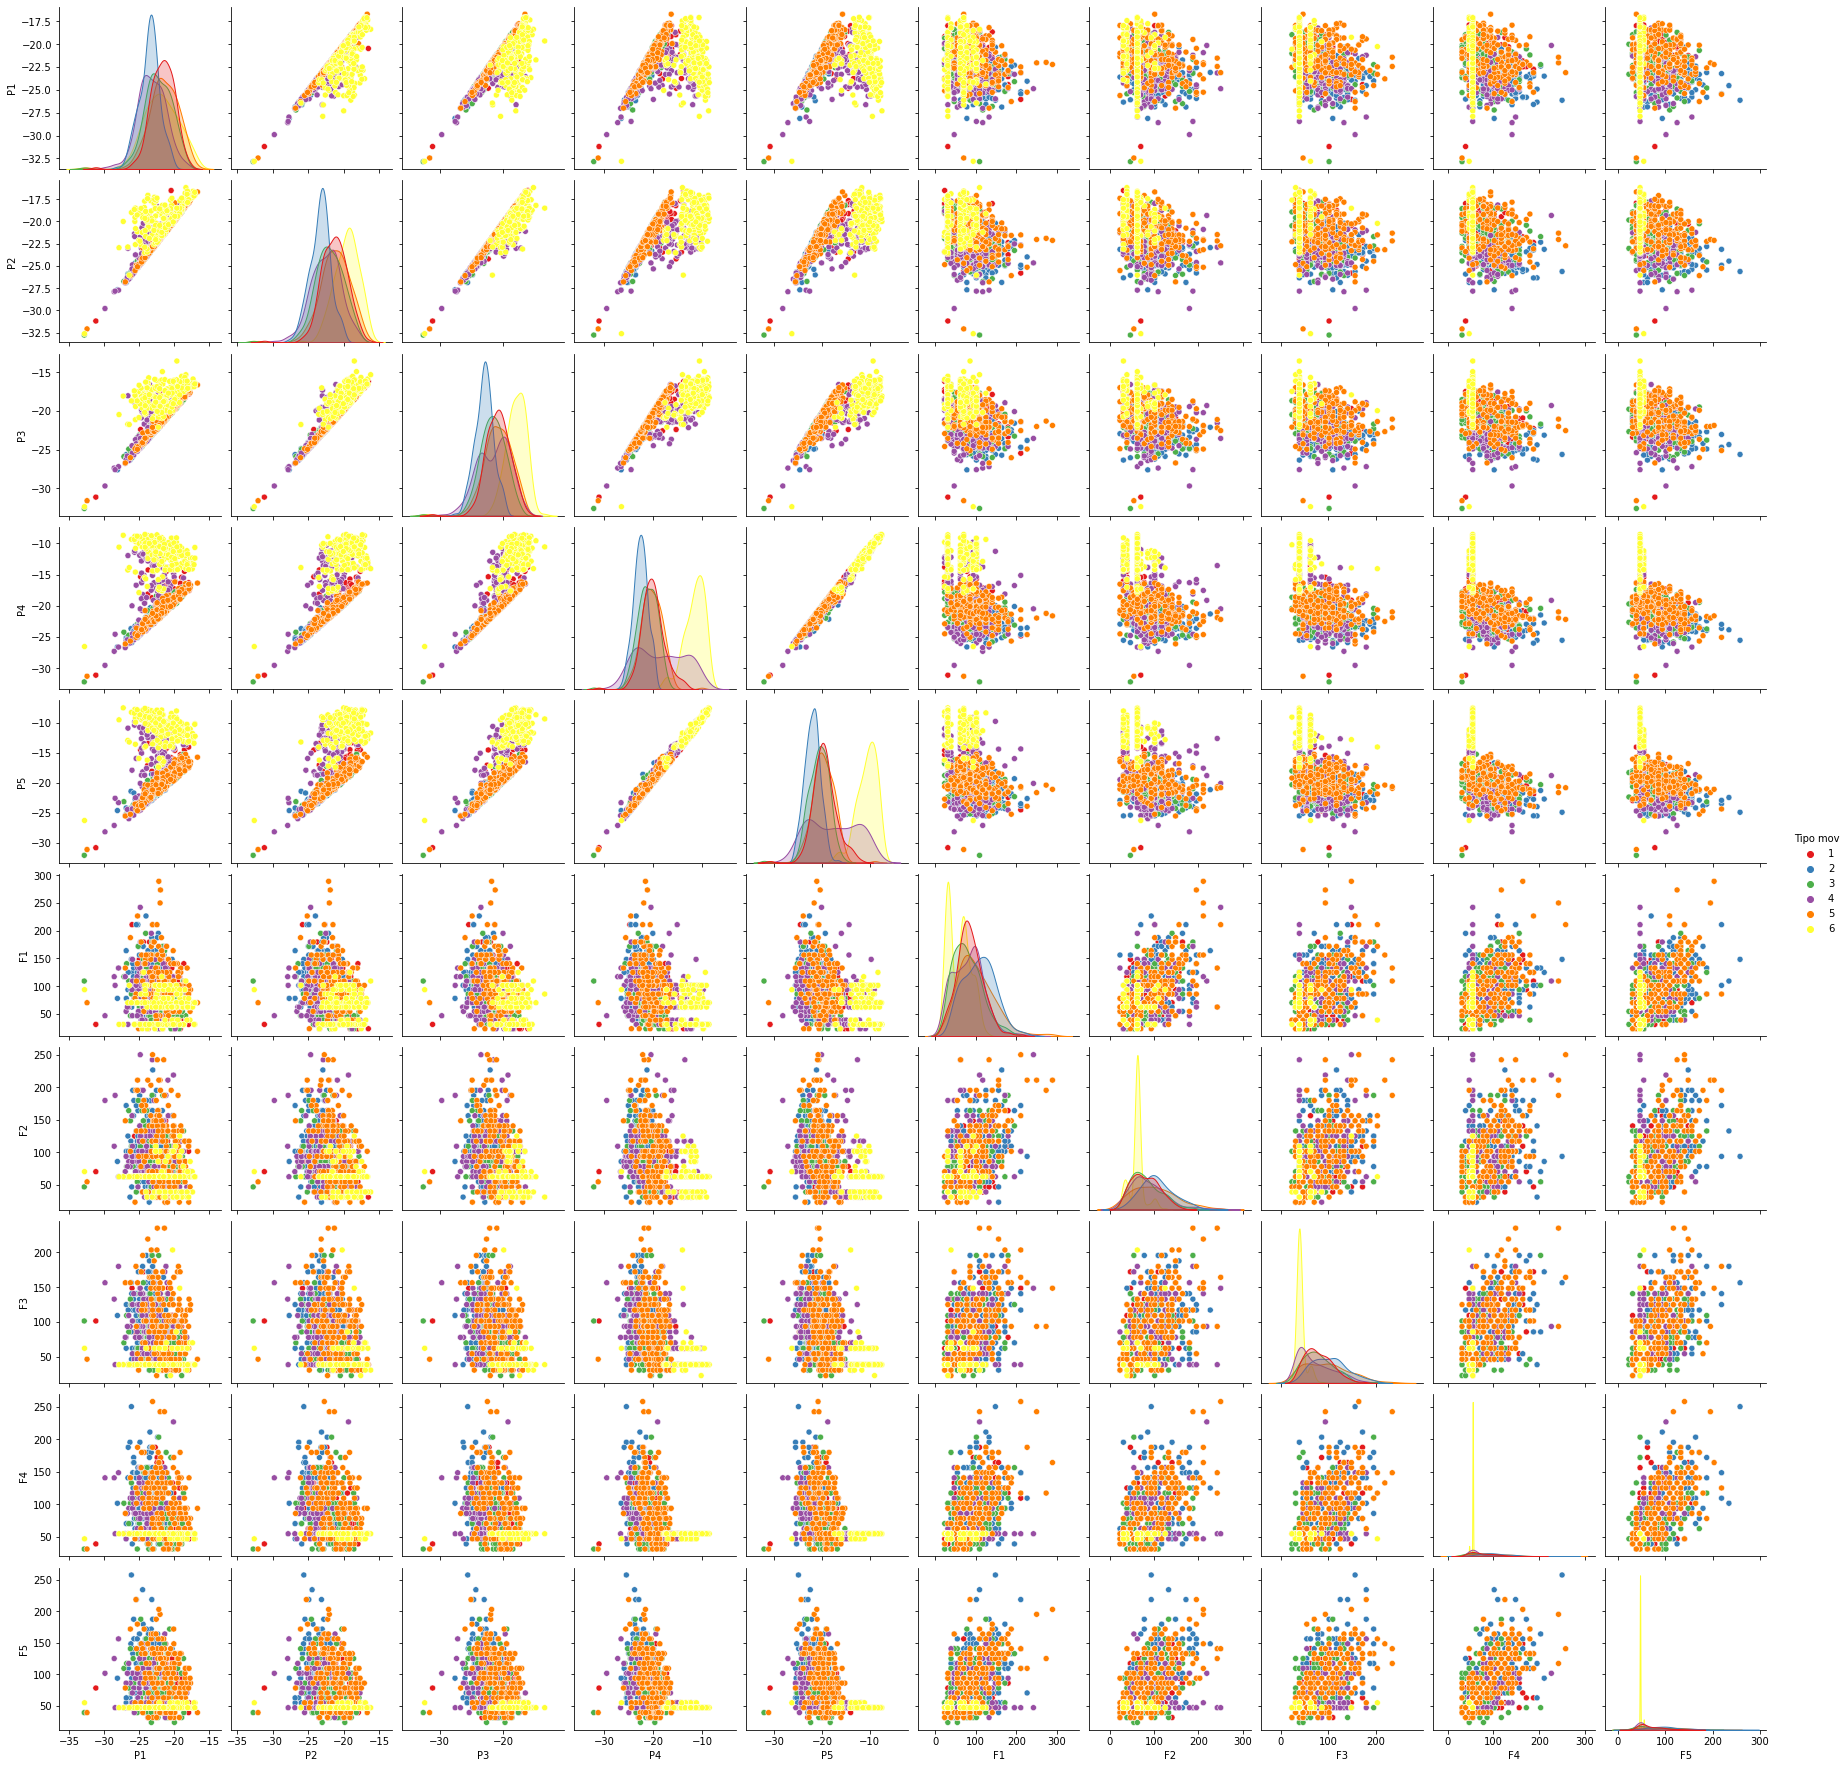

In [23]:
import seaborn as sns

subdataFrame = CompletedataFrame[['P1','P2','P3','P4','P5','F1','F2','F3','F4','F5',"Tipo mov"]]

sns.pairplot(subdataFrame, hue="Tipo mov", palette =  sns.color_palette("Set1",6))

Como se esperaba, la relación de las potencias con el contenido frecuencial de cada movimiento al completo no muestra una clara relación, los datos aparecen mucho mas mezclados que con la primera descomposición, por lo que es natural pensar que con una descomposición mayor se pueda tener una segmentación mas clara al haber intervalos de frecuencia mas estrechos.

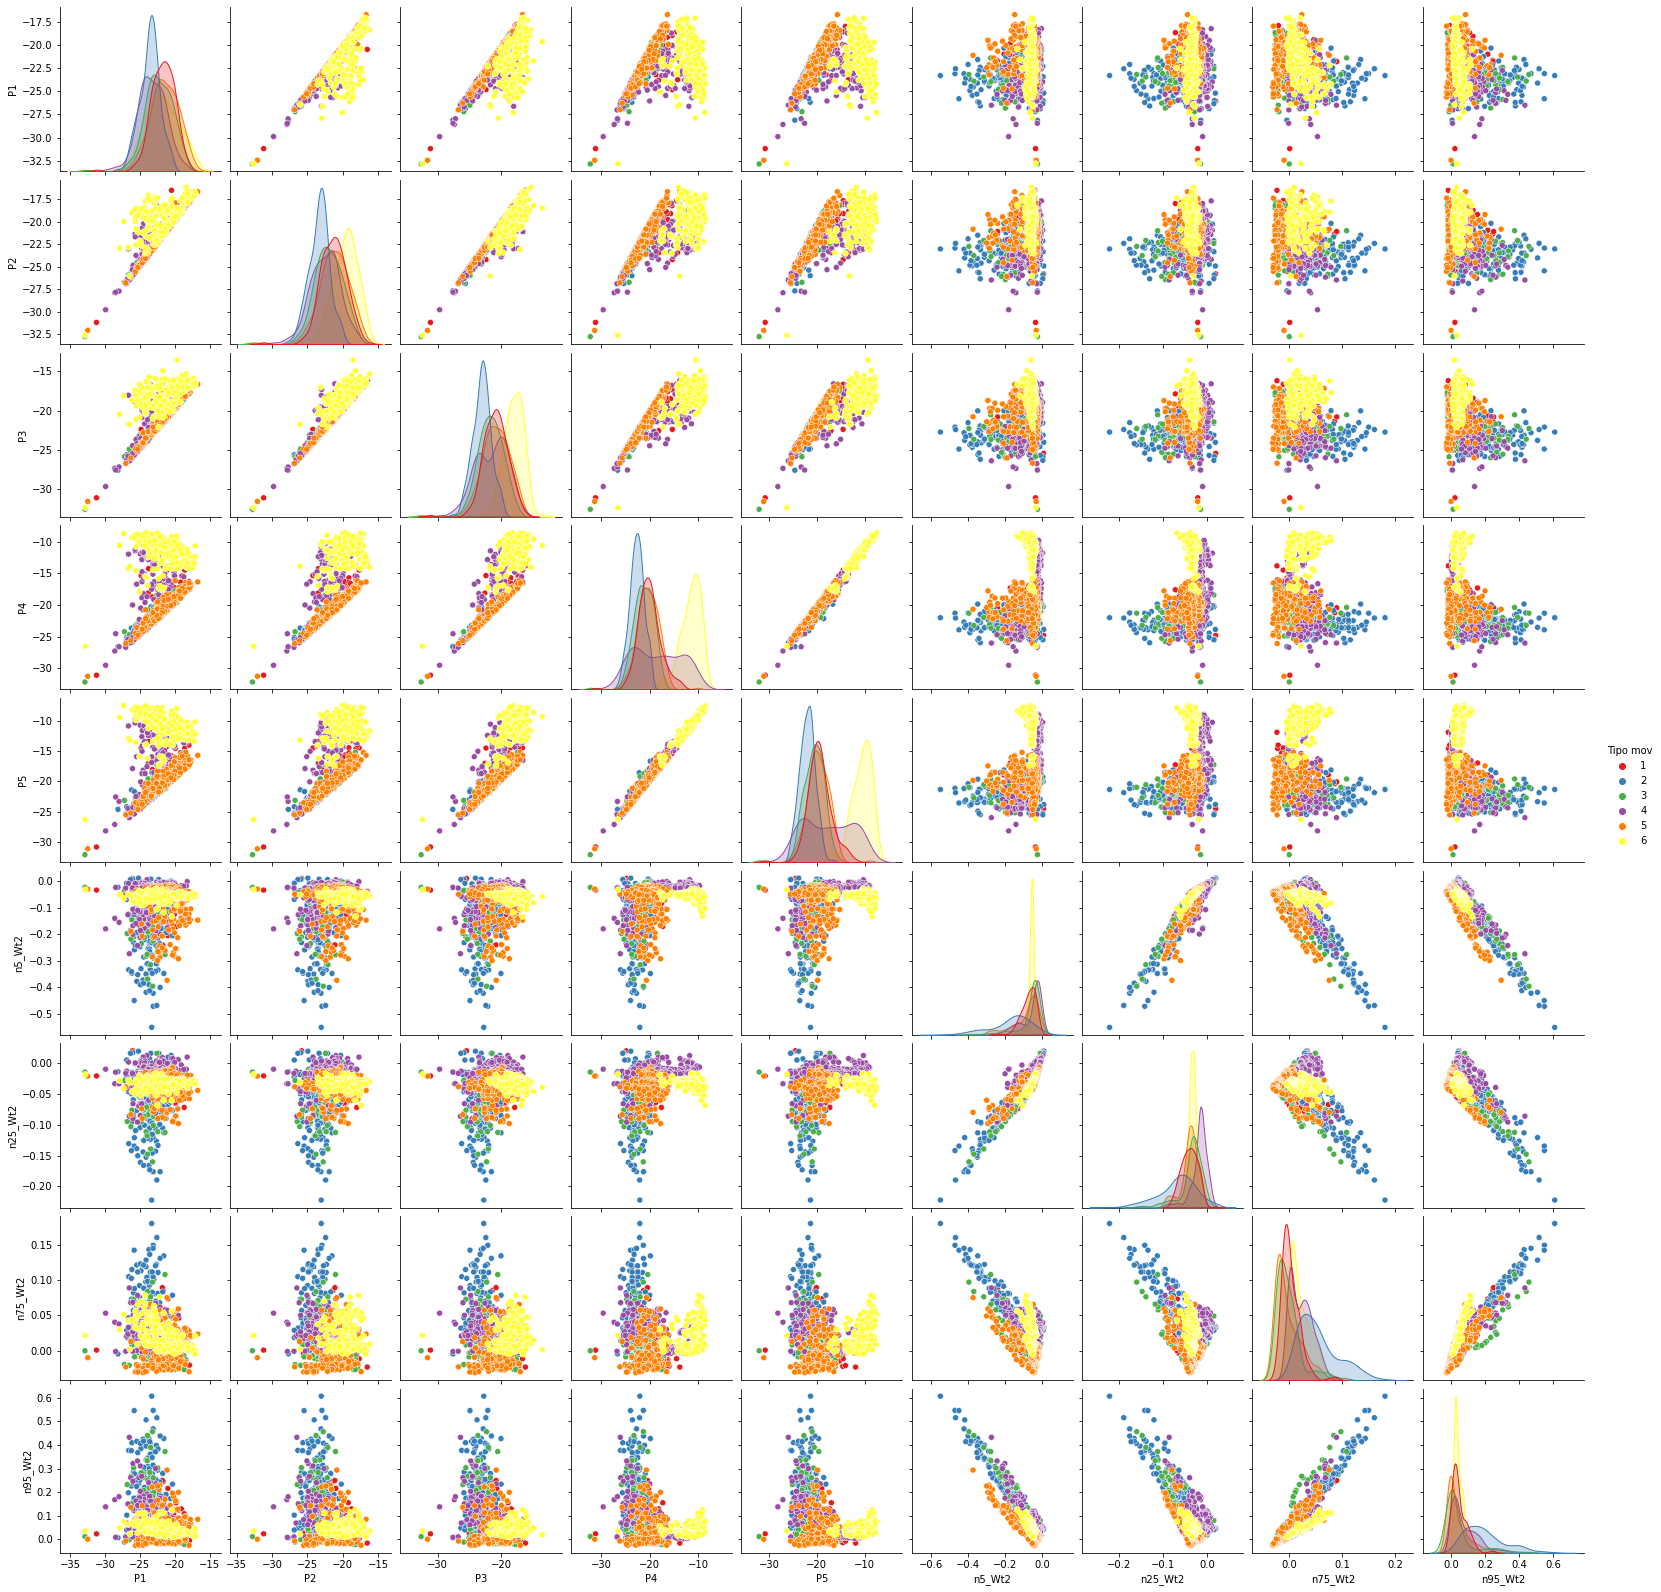

In [ ]:
import seaborn as sns

subdataFrame = CompletedataFrame[['P1','P2','P3','P4','P5','n5_Wt2', 'n25_Wt2', 'n75_Wt2', 'n95_Wt2',"Tipo mov"]]

sns.pairplot(subdataFrame, hue="Tipo mov", palette =  sns.color_palette("Set1",6))

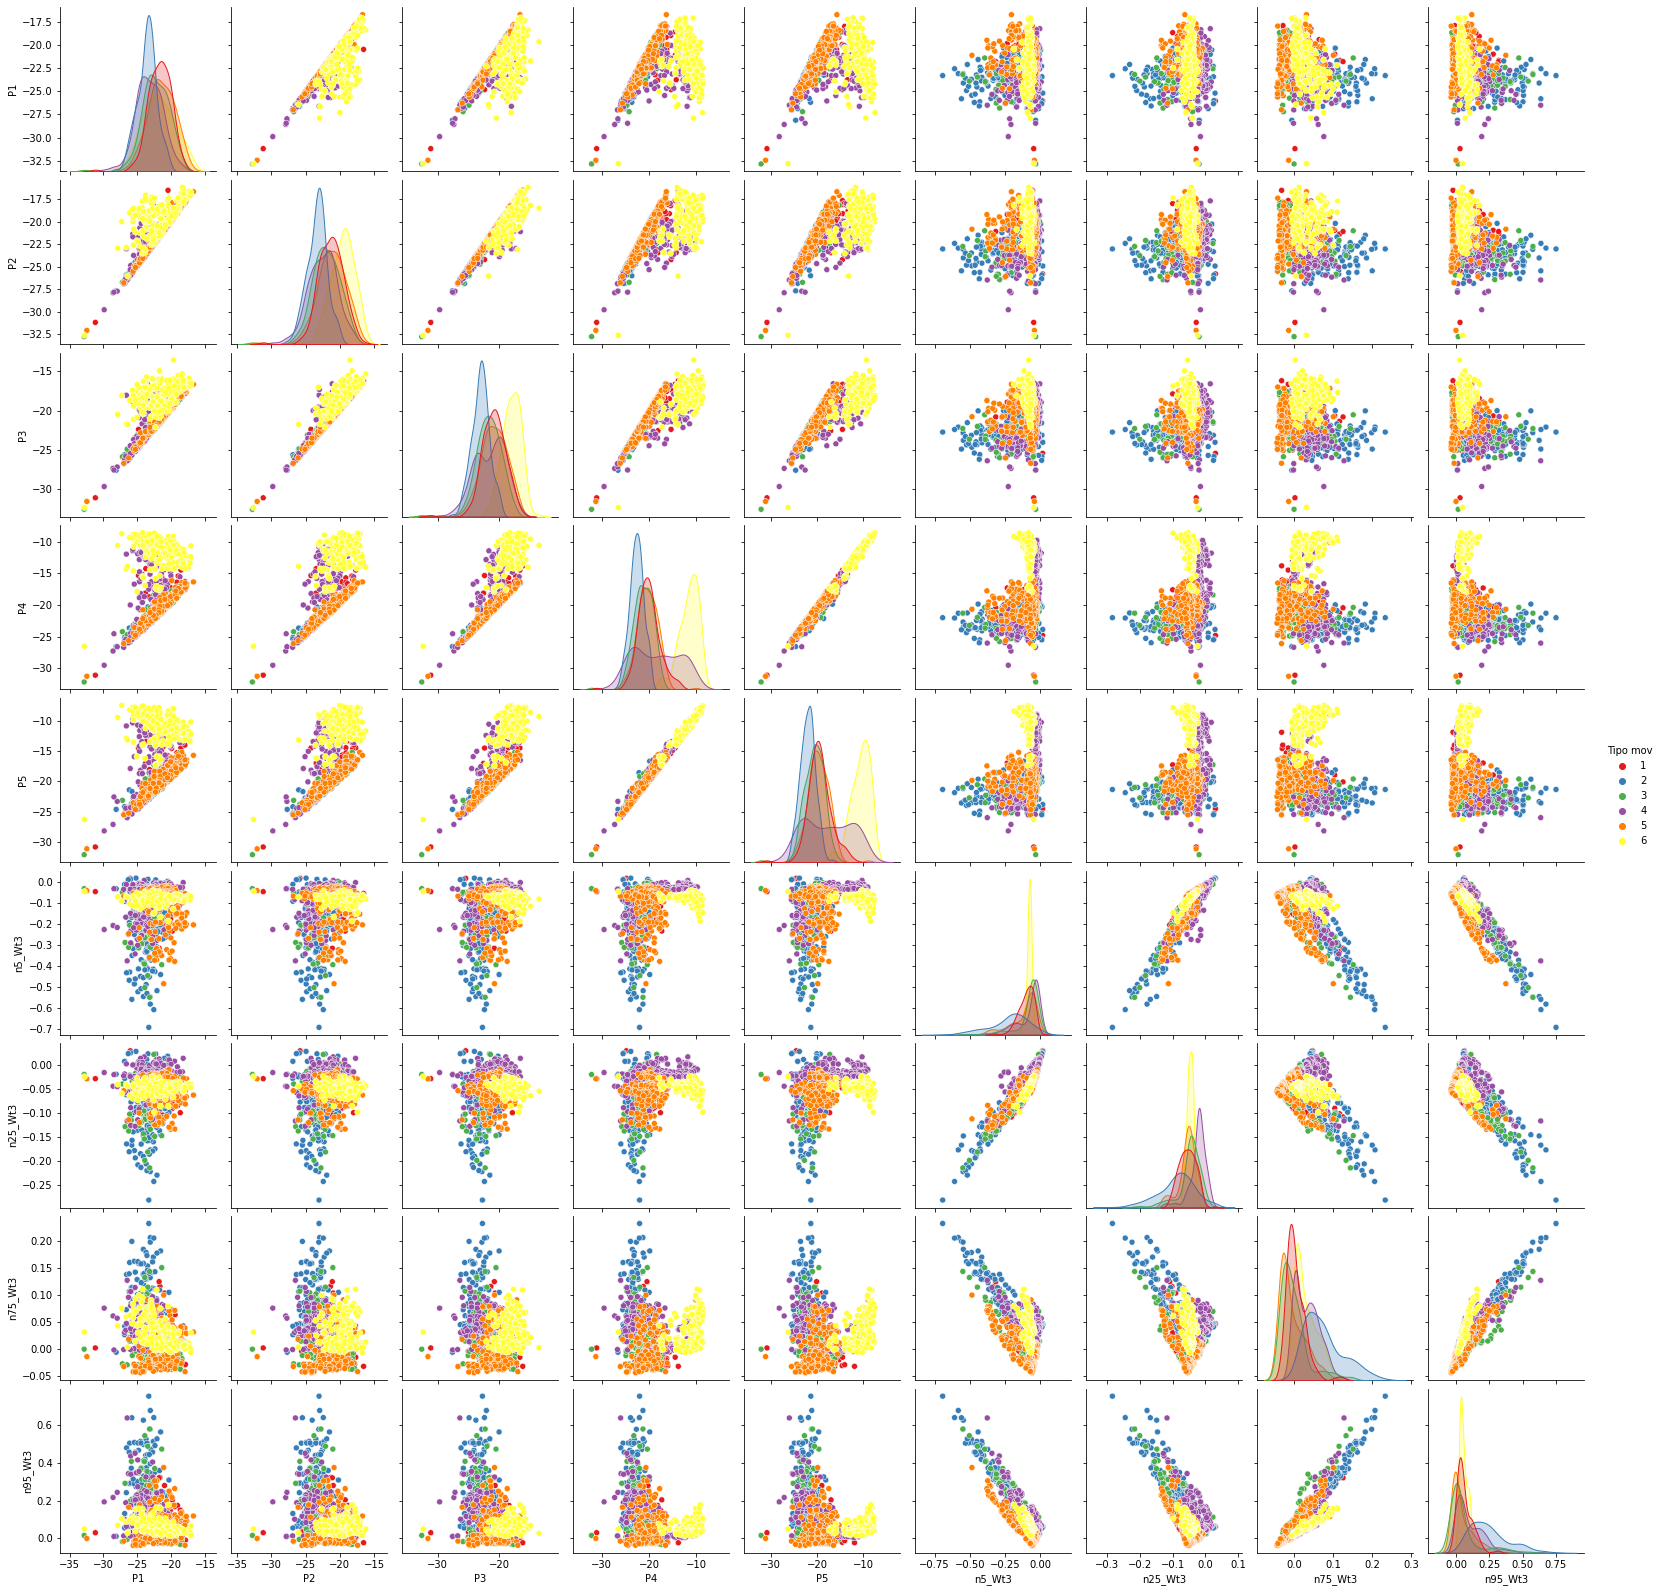

In [24]:
import seaborn as sns

subdataFrame = CompletedataFrame[['P1','P2','P3','P4','P5','n5_Wt3', 'n25_Wt3', 'n75_Wt3', 'n95_Wt3',"Tipo mov"]]

sns.pairplot(subdataFrame, hue="Tipo mov", palette =  sns.color_palette("Set1",6))

# **Analisis** 

Se nota el mismo patrón de comportamiento con las características mediana, media y std (desviación estándar) en los M niveles de descomposición de las señales.
La característica que más información brindó en casi todos los casos es la entropía, en este caso las M entropías de los M niveles de descomposición de la señal.
En el caso del sujeto de prueba 1, los movimientos más separables e identificables (con ayuda del diagrama de pares) son C2 (color naranja) correspondiente al movimiento de abrir la mano y C6 (color amarillo) correspondiente a la desviación radial de muñeca. En algunos casos también fue posible identificar el movimiento C5 (color verde) correspondiente a la desviación cubital de muñeca. En los otros movimientos: C1 correspondiente a cerrar la mano, C3 correspondiente a extensión de muñeca y C4 correspondiente a flexión de muñeca, representados con los colores verde agua, azul y rosado respectivamente, no se identificó una buena separación con los otros movimientos o un grupo lo suficientemente compacto como para ser identificado facilmente.
En el caso del sujeto dos, se esperaba apreciar las mismas separaciones con los mismos colores que con el sujeto anterior, pero se encuentran otras separaciones de otros colores (en este caso se separa muy bien el verde agua, color que el primer sujeto no mostraba facilmente), llegando a la conclusión de que a pesar de que a todos los sujetos de prueba realizan los mismos movimientos, las características aplicadas no dan la misma información de todos estos (por lo menos en los tres casos de análisis), brindando en algunos casos información de un movimiento diferente.
La gráfica de distribución presente en la diagonal principal del modelo de visualización de pares característicos también da información sobre la separabilidad de los grupos, teniendo en cuenta la distancia de separación de los picos de cada función.

1.   List item
2.   List item

